# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N°1: Puntos de colocacion

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [3]:
pressure_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:31:06 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'p': array([[0.00000000e+00, 1.62864847e-05, 1.31113620e-05, ...,
         1.05833522e+00, 1.66906380e+00, 3.40199098e+00]])}

In [4]:
velocity_raw_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Apr  5 20:33:39 2023',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[0.   , 0.01 , 0.02 , ..., 0.975, 0.985, 0.995]]),
 'y': array([[0.   , 0.   , 0.   , ..., 0.995, 0.995, 0.995]]),
 'z': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'u': array([[0.        , 0.        , 0.        , ..., 0.65946941, 0.49345089,
         0.17337734]]),
 'v': array([[ 0.        ,  0.        ,  0.        , ..., -0.03262434,
         -0.06381343, -0.15660411]]),
 'w': array([[0., 0., 0., ..., 0., 0., 0.]])}

### 1. Xpde y Xbc

In [5]:
# n_pde debe ser = n^2 para grilla regular
n_pde = 1024
n_bc= 100

x_lb = 0
x_ub = 1
y_lb = 0
y_ub = 1

#### Grilla regular

In [6]:
def get_xy_pde_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(np.sqrt(n) + 1)
    y_step = (y_bounds[1]-y_bounds[0])/(np.sqrt(n) + 1)
    x = np.arange(x_bounds[0] + x_step, x_bounds[1], x_step)
    y = np.arange(y_bounds[0]  + y_step, y_bounds[1], y_step)
    return np.array([[x_i, y_i] for x_i in x for y_i in y])

xy_pde_mesh = get_xy_pde_mesh([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [7]:
def get_xy_bc_mesh(x_bounds, y_bounds, n):
    x_step = (x_bounds[1]-x_bounds[0])/(n / 4)
    y_step = (y_bounds[1]-y_bounds[0])/(n / 4)
    l1 = np.array([[x_i, y_bounds[0]] for x_i in np.arange(x_bounds[0], x_bounds[1], x_step)])
    l2 = np.array([[x_bounds[1], y_i] for y_i in np.arange(y_bounds[0], y_bounds[1], y_step)])
    l3 = np.array([[x_i, y_bounds[1]] for x_i in np.arange(x_bounds[1], x_bounds[0], -x_step)])
    l4 = np.array([[x_bounds[0], y_i] for y_i in np.arange(y_bounds[1], y_bounds[0], -y_step)])
    return np.concatenate([l1,l2,l3,l4], axis=0)

xy_bc_mesh = get_xy_bc_mesh([x_lb, x_ub], [y_lb, y_ub], n_bc)

#### Muestreo aleatorio

In [8]:
def get_xy_pde_random(x_bounds, y_bounds, n):
    x = np.random.uniform(np.nextafter(x_bounds[0], x_bounds[1]), x_bounds[1], n)
    y = np.random.uniform(np.nextafter(y_bounds[0], y_bounds[1]), y_bounds[1], n)
    return np.array([[x[i], y[i]] for i in range(n)])

xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], n_pde)

In [9]:
def get_xy_bc_random(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        elif side == 'right':
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], np.random.uniform(y_bounds[0], y_bounds[1], 1)[0]])
        else:  # side == 'left'
            xy.append([np.random.uniform(x_bounds[0], x_bounds[1], 1)[0], y_bounds[0]])
    return np.array(xy)

xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], n_bc)

### 2. Graficar puntos de colocación

#### Grilla regular

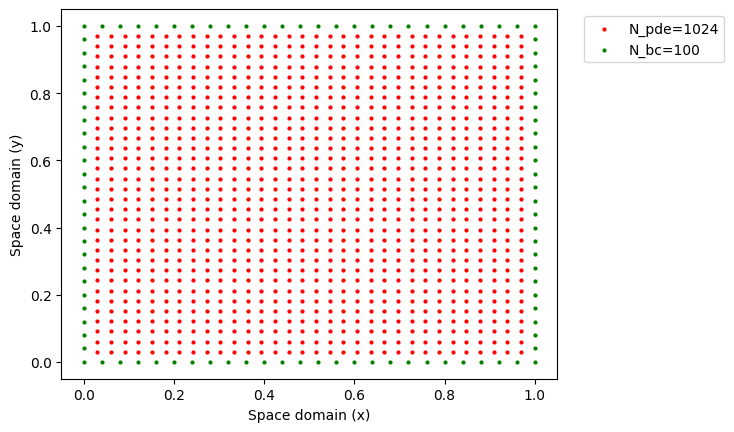

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_mesh[:,0], xy_pde_mesh[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_mesh[:,0], xy_bc_mesh[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

#### Muestreo aleatorio

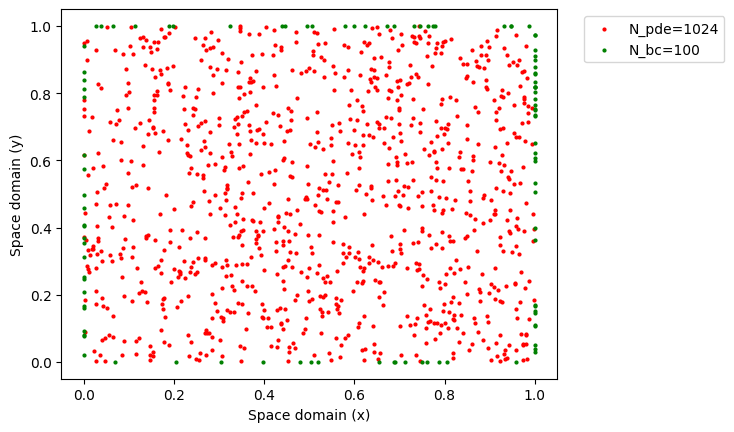

In [11]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_pde_random[:,0], xy_pde_random[:,1], s=4, c='r', label=f'N_pde={len(xy_pde_mesh)}')
ax.scatter(xy_bc_random[:,0], xy_bc_random[:,1], s=4, c='g', label=f'N_bc={len(xy_bc_mesh)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

### 3. Datos rotulados

In [12]:
n_data = 10

In [13]:
def get_ds_data(pressure_ds, velocity_ds, n):
    idxs = [random.randrange(0, len(pressure_raw_data['x'][0])) for _ in range(n)]
    xy = []
    labels = []
    for idx in idxs:
        assert pressure_ds['x'][0][idx] == velocity_ds['x'][0][idx]
        assert pressure_ds['y'][0][idx] == velocity_ds['y'][0][idx]
        xy.append([pressure_ds['x'][0][idx], pressure_ds['y'][0][idx]])
        labels.append([velocity_ds['u'][0][idx], velocity_ds['v'][0][idx], pressure_ds['p'][0][idx]])
    return np.array(xy), np.array(labels)

xy_data_random, labels_data_random = get_ds_data(pressure_raw_data, velocity_raw_data, n_data)

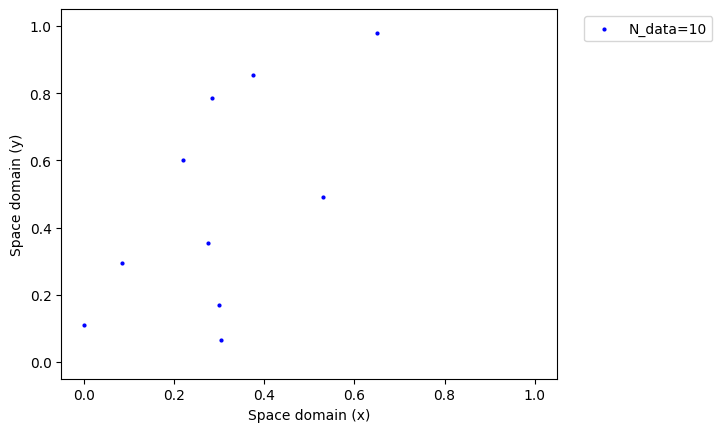

In [14]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(xy_data_random[:,0], xy_data_random[:,1], s=4, c='b', label=f'N_data={len(xy_data_random)}')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend()
plt.xlabel('Space domain (x)')
plt.ylabel('Space domain (y)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

Este dataset de datos rotulados contiene no solamente los valores de input (x e y) del modelo sino también los valores de las etiquetas/salidas (p, u, v), por lo que constituye un caso de entrenamiento supervisado. En cambio, los datasets de puntos de colocación contienen solamente los valores de input (x e y) del modelo, por lo que se asemejaría más a un problema no supervisado, pero en realidad lo convertimos en "supervisado" a traves del uso de las EDP.

Como la estructura del dataset de datos rotulados y la de los datasets de puntos de colocación son diferentes, no podremos concatenarlos y seleccionar aleatoriamente batch que incluyan puntos de ambos al mismo tiempo. En su lugar, tendremos que entrenar el modelo de a pasos.

### 4. Para pensar

El sub-conjunto de los puntos de colocación xy_pde no debería contener puntos sobre la frontera del dominio, ya que la definición de la PDE se hace sobre el conjunto abierto del dominio (sin incluir el borde).

## TP N°2: Modelado PINN

### 1. Rutina PINN

Las ecuaciones vectoriales de Navier-Stokes incompresibles para 2D pueden ser desarrolladas como

$$ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= -\frac{\partial p}{\partial x} + 1/R_e(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}), \text{ en } \Omega $$

$$ u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= -\frac{\partial p}{\partial y} + 1/R_e(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}), \text{ en } \Omega $$

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0, \text{ en } \Omega $$

In [15]:
import torch
import torch.nn as nn

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
 class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.Reynolds = model_parameters["Reynolds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)


    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def pdeResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0]
        v = output[:,1]
        p = output[:,2]
        
        # Compute the derivatives of the outputs u,v and p over the inputs (x,y) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        u_x, u_y = diff_u[:, 0:1], diff_u[:, 1:2]
        v_x, v_y = diff_v[:, 0:1], diff_v[:, 1:2]
        p_x, p_y = diff_p[:, 0:1], diff_p[:, 1:2]
        

        # Compute the second derivative of the outputs u and v over the inputs (x,y) using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Compute residues
        residue_1 = u_x + v_y
        residue_2 = u * u_x + v * u_y + p_x - (1/self.Reynolds) * (u_xx + u_yy)
        residue_3 = u * v_x + v * v_y + p_y - (1/self.Reynolds) * (v_xx + v_yy)
        return residue_1 + residue_2 + residue_3

    def bcResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0]
        v = output[:,1]
        p = output[:,2]

        # Calculate true bc values 
        u_bc = (X[:,1] == 1) * 1.0 # u = 1 only at upper y bound, else 0
        v_bc = torch.zeros_like(v) # v = 0 on all border

        residue_1 = u - u_bc
        residue_2 = v - v_bc
        return residue_1 + residue_2
        

In [18]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

### 2. Resolver PINN

In [19]:
model_parameters = {
    "Device": device,
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 20,
    "NumberOfHiddenLayers": 8,
    "ActivationFunction": nn.Tanh()
}

torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [20]:
# Initialization of data structures
xy_pde_random = get_xy_pde_random([x_lb, x_ub], [y_lb, y_ub], 10_000)
xy_bc_random = get_xy_bc_random([x_lb, x_ub], [y_lb, y_ub], 1_000)

epochs = 15000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train = {'Overall' : [], 'PDE': [], 'BC': []}

for epoch in range(epochs):
    optimizer.zero_grad()

    # PDE
    X_pde = torch.tensor(xy_pde_random, requires_grad = True).float().to(device)
    output_pde = model(X_pde)
    y_hat_pde = model.pdeResidue(X_pde, output_pde)
    loss_pde = loss_fn(y_hat_pde, torch.zeros_like(y_hat_pde))
    
    # BC
    X_bc = torch.tensor(xy_bc_random, requires_grad = True).float().to(device)
    output_bc = model(X_bc)
    y_hat_bc = model.bcResidue(X_bc, output_bc)
    loss_bc = loss_fn(y_hat_bc, torch.zeros_like(y_hat_bc))

    # Loss, backpropagation and gradient descent
    loss_overall = loss_pde + loss_bc
    loss_overall.backward()
    optimizer.step()

    # Log
    loss_train['Overall'].append(loss_overall.item())
    loss_train['PDE'].append(loss_pde.item())
    loss_train['BC'].append(loss_bc.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item()}, PDE: {loss_pde.item()}, BC: {loss_bc.item()}")

Epoch 1/15000 - Loss Overall: 0.3552490472793579, PDE: 9.300779493059963e-05, BC: 0.3551560342311859
Epoch 101/15000 - Loss Overall: 0.18801076710224152, PDE: 0.0006450520013459027, BC: 0.18736571073532104
Epoch 201/15000 - Loss Overall: 0.16913045942783356, PDE: 0.0007259470294229686, BC: 0.16840451955795288
Epoch 301/15000 - Loss Overall: 0.11410674452781677, PDE: 0.00045920151751488447, BC: 0.11364754289388657
Epoch 401/15000 - Loss Overall: 0.08144711703062057, PDE: 0.0013818491715937853, BC: 0.08006526529788971
Epoch 501/15000 - Loss Overall: 0.06529956310987473, PDE: 0.0011414802866056561, BC: 0.06415808200836182
Epoch 601/15000 - Loss Overall: 0.0496433861553669, PDE: 0.0007162751280702651, BC: 0.04892710968852043
Epoch 701/15000 - Loss Overall: 0.035726871341466904, PDE: 0.00046488409861922264, BC: 0.03526198863983154
Epoch 801/15000 - Loss Overall: 0.026779787614941597, PDE: 0.0007696305983699858, BC: 0.02601015754044056
Epoch 901/15000 - Loss Overall: 0.02102809026837349, PDE

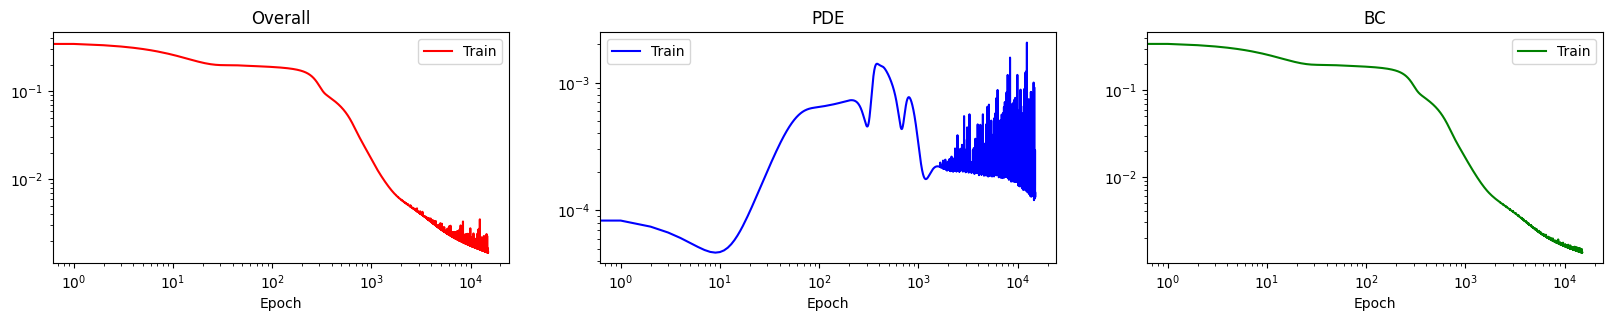

In [21]:
# Evolution of the loss function
fig, ax = plt.subplots(1, len(loss_train), figsize=(20, 3))
colors = ['red', 'blue', 'green']
for i, loss_type in enumerate(loss_train):
    epoch_train = np.arange(0, len(loss_train[loss_type]))
    ax[i].loglog(epoch_train, loss_train[loss_type], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(loss_type)
    ax[i].legend()
plt.show()

In [28]:
torch.save(model.state_dict(), "./model.pt")

### 3. Calculo de error

In [37]:
xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [38]:
model.train(False)
with torch.no_grad():
    X_data = torch.tensor(xy_data_all).float().to(device)
    output_data = model(X_data).cpu().numpy()

In [39]:
def l2_norm(y_pred, y_true):
    return np.sqrt(np.sum((y_pred - y_true)**2))

In [40]:
u_l2_norm = l2_norm(output_data[:,0], labels_data_all[:,0])
v_l2_norm = l2_norm(output_data[:,1], labels_data_all[:,1])
p_l2_norm = l2_norm(output_data[:,2], labels_data_all[:,2])
print(f"Normal L2 del error en u: {u_l2_norm}, v: {v_l2_norm}, p: {p_l2_norm}")

Normal L2 del error en u: 196.70359908057054, v: 196.05354673251904, p: 351.7320271484255


### 4. Graficas error absoluto

In [41]:
from matplotlib import cm

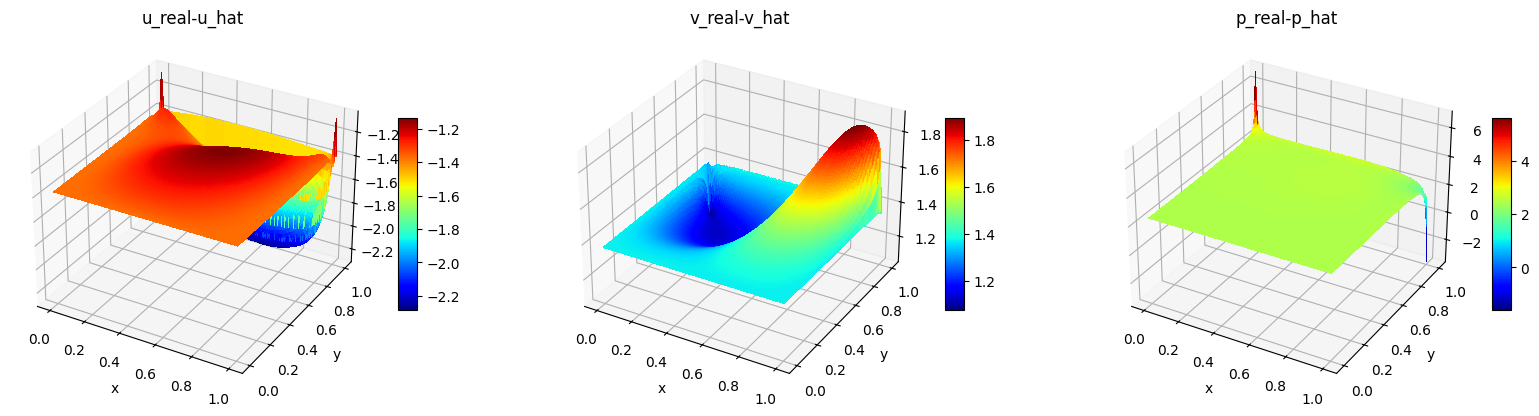

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw=dict(projection='3d'))
# u graph
ax = axs[0]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,0]-labels_data_all[:,0], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('u_real-u_hat')

# v graph
ax = axs[1]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,1]-labels_data_all[:,1], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('v_real-v_hat')

# p graph
ax = axs[2]
surf = ax.plot_trisurf(xy_data_all[:,0], xy_data_all[:,1], output_data[:,2]-labels_data_all[:,2], cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('p_real-p_hat')
plt.show()

### 5. Analisis

De acuerdo a lo observado, el modelo no parece ser lo suficientemente bueno para predecir los campos de presión y velocidad.

En la evolución de la pérdida, se observa que la componente relacionada con el residuo de la PDE comienza siendo baja y luego aumenta por consecuencia de ajustar la componente asociada a la condición de borde. Al finalizar el entrenamiento, si bien hubo mejora de la pérdida asociada a la condición de borde, esta es 1 orden de magnitud mayor que la asociada a la PDE.

De las gráficas del error absoluto, se obserba que el mayor error se encuentra en la zona de y=1 para u (donde se debería cumplir la condición de borde u=1), en la zona de x tendiendo a 1 para v, y en el vértice (0,1) para p.

Considero que los hiperparámetros seleccionados no son los mejores pero tampoco incorrectos, y que una optimización de los mismos solo produciría mejoras márginales. En este caso donde el error es grande, para lograr mejoras sustanciales es necesario considerar cambios en la arquitectura de la solución.

Para mejorar el desempeño podríamos por ejemplo reemplazar la arquitectura por una implementación "hard" de las condiciones de borde, ya que es donde se encontraron los mayores errores.